### Direct Search
Likely to be MORDM
1) Initialize Model/ Problem Specification
2) Search Candidate Solutions (based on Ref Scenario)
3) Re-Evaluate Solutions under Uncertainty (Many Scenario)
4) Save Results

In [3]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# EMA
from ema_workbench import (Model, RealParameter,  Scenario, MultiprocessingEvaluator, ScalarOutcome, perform_experiments, ema_logging)
from ema_workbench import Samplers, Policy
from ema_workbench import save_results, load_results
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.analysis import parcoords
# Model
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)
# parameter definition for visualization libraries
plt.rcParams["figure.figsize"] = (10, 6)
sns.set_style("whitegrid")

/usr/local/lib/python3.11/site-packages/ema_workbench/analysis/prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive " "inspection not available"), ImportWarning)


### 1) Initialize Model

In [14]:
#------------------------- Set Model Parameters
problem_formulation = 6
model, steps = get_model_for_problem_formulation(problem_formulation)

uncertainties = model.uncertainties
levers = model.levers
outcomes = model.outcomes

#------------------------- Reference Scenario
ref_val = {'Bmax': 175, 
           'Brate': 1.5, 
           'pfail': 0.5,
            'discount rate': 3.5,
            'ID flood wave shape': 4}

ref_dict = {}
# < ref_dict >
# reference scenario updated for all dike rings
for key in model.uncertainties:
    name_split = key.name.split('_')
    if len(name_split) == 1:
        if key.name in ref_val.keys():
            ref_dict.update({key.name: ref_val[key.name]})
    else:
        ref_dict.update({key.name: ref_val[name_split[1]]})


#------------------------- Optimization Parameters

ref_scenario = Scenario('reference', **ref_dict)

convergence_metrics = [EpsilonProgress()]
nfe = 50000

In [3]:
for policy in model.levers:
    print(repr(policy))

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable_name=['3_RfR 0'], pff=False)
IntegerParameter('4_RfR 0', 0, 1, resolution=None, default=None, variable_name=['4_RfR 0'], pff=False)
IntegerParameter('EWS_DaysToThreat', 0, 1, resolution=None, default=None, variable_name=['EWS_DaysToThreat'], pff=False)
IntegerParameter('A.1_DikeIncrease 0', 0, 10, resolution=None, default=None, variable_name=['A.1_DikeIncrease 0'], pff=False)
IntegerParameter('A.2_DikeIncrease 0', 0, 10, resolution=None, default=None, variable_name=['A.2_DikeIncrease 0'], pff=False)
IntegerParameter('A.3_DikeIncrease 0', 0, 10, resolution=None, default=None, variable_name=['A.3_DikeIncrease 0'

### 2) Search Candidate Solutions (based on Ref Scenario)
- Run Optimization on Lever Space
- Find Candidate Policies

In [4]:
'''

ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model, n_processes = 6) as evaluator:
    results1, convergence = evaluator.optimize(nfe=nfe,
                                            searchover='levers',
                                            epsilons=[0.1]*len(model.outcomes),
                                              convergence=convergence_metrics,
                                            reference=ref_scenario
                                            )
    
results1.to_csv('results/optimization_{}_{}_noEWS.csv'.format(problem_formulation,nfe))

'''

"\n\nema_logging.log_to_stderr(ema_logging.INFO)\nwith MultiprocessingEvaluator(model, n_processes = 6) as evaluator:\n    results1, convergence = evaluator.optimize(nfe=nfe,\n                                            searchover='levers',\n                                            epsilons=[0.1]*len(model.outcomes),\n                                              convergence=convergence_metrics,\n                                            reference=ref_scenario\n                                            )\n    \nresults1.to_csv('results/optimization_{}_{}_noEWS.csv'.format(problem_formulation,nfe))\n\n"

In [4]:
# final result data set
results = pd.read_csv("results/optimization_6_50000_noEWS.csv")
#show max, min etc for all outcomes
results.describe()

,Unnamed: 0,0_RfR 0,1_RfR 0,2_RfR 0,3_RfR 0,4_RfR 0,EWS_DaysToThreat,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,...,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Dike Investment Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
count,8108.000000,8108.000000,8108.000000,8108.000000,8108.000000,8108.000000,8108.000000,8108.000000,8108.000000,8108.000000,...,8.108000e+03,8108.000000,8.108000e+03,8.108000e+03,8108.000000,8.108000e+03,8.108000e+03,8108.000000,8.108000e+03,8108.0
mean,4053.500000,0.393562,0.158855,0.527627,0.529600,0.240997,0.516897,2.208066,3.113098,2.665269,...,2.148427e+07,0.011785,3.209878e+06,6.738036e+06,0.000661,2.114984e+07,2.459851e+07,0.007577,2.099990e+08,0.0
std,2340.722324,0.488570,0.365564,0.499267,0.499154,0.427715,0.499745,1.997655,1.799884,1.862802,...,8.896845e+06,0.018201,4.799255e+06,3.710479e+06,0.000968,3.622034e+07,1.320404e+07,0.012959,1.779099e+08,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0
25%,2026.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,...,2.029929e+07,0.000000,0.000000e+00,6.320800e+06,0.000000,0.000000e+00,2.503721e+07,0.000000,8.460000e+07,0.0
50%,4053.500000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,2.000000,3.000000,3.000000,...,2.419803e+07,0.002115,4.779633e+05,7.332080e+06,0.000107,0.000000e+00,2.757823e+07,0.000000,1.519000e+08,0.0
75%,6080.250000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,3.000000,4.000000,4.000000,...,2.640338e+07,0.018256,5.421202e+06,8.453408e+06,0.001132,3.669789e+07,3.035153e+07,0.013127,3.697000e+08,0.0
max,8107.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,10.000000,10.000000,...,4.421502e+07,0.092239,1.861630e+07,2.038434e+07,0.003788,1.478810e+08,5.817663e+07,0.053026,7.104000e+08,0.0


### 3) Re-Evaluate Solutions under Uncertainty (Few Candidate Policies, Many Scenario)


#### 3a Constrain Conditions

In [5]:
#Create aggregate columns for death, damage and investment cost
results["Gelderland_Deaths"] = results[[f"A.{i+1}_Expected Number of Deaths" for i in range(3)]].sum(axis=1)
results["Gelderland_Damages"] = results[[f"A.{i+1}_Expected Annual Damage" for i in range(3)]].sum(axis=1)
results["Gelderland_Investment"] = results[[f"A.{i+1}_Dike Investment Costs" for i in range(3)]].sum(axis=1)
results["Overijssel_Deaths"] = results[[f"A.{i}_Expected Number of Deaths" for i in [4, 5]]].sum(axis=1)
results["Overijssel_Damages"] = results[[f"A.{i}_Expected Annual Damage" for i in [4, 5]]].sum(axis=1)
results["Overijssel_Investment"] = results[[f"A.{i}_Dike Investment Costs" for i in [4, 5]]].sum(axis=1)
results["Total_Deaths"] = results["Gelderland_Deaths"] + results["Overijssel_Deaths"]
results["Total_Damages"] = results["Gelderland_Damages"] + results["Overijssel_Damages"]
results["Total_Investment"] = results["Gelderland_Investment"] + results["Overijssel_Investment"]+results['RfR Total Costs']
results["Gelderland_RfR"] = results[[f"{i}_RfR 0" for i in range(3)]].sum(axis=1)
results["Overijssel_RfR"] = results[[f"{i}_RfR 0" for i in [3, 4]]].sum(axis=1)

results

,Unnamed: 0,0_RfR 0,1_RfR 0,2_RfR 0,3_RfR 0,4_RfR 0,EWS_DaysToThreat,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,...,Gelderland_Damages,Gelderland_Investment,Overijssel_Deaths,Overijssel_Damages,Overijssel_Investment,Total_Deaths,Total_Damages,Total_Investment,Gelderland_RfR,Overijssel_RfR
0,0,1,1,1,1,1,0,0,3,1,...,1.951891e+07,6.814199e+07,0.001223,6.099298e+06,4.027367e+07,0.014495,2.561820e+07,8.188157e+08,3,2
1,1,1,0,0,0,0,0,0,3,6,...,4.924467e+06,7.924150e+07,0.000000,0.000000e+00,4.444589e+07,0.001920,4.924467e+06,2.082874e+08,1,0
2,2,1,1,1,1,1,0,1,4,1,...,1.793119e+07,1.063528e+08,0.001223,6.099298e+06,5.817663e+07,0.013881,2.403049e+07,8.749294e+08,3,2
3,3,0,1,0,0,1,1,5,1,0,...,1.546264e+08,9.221763e+07,0.000511,2.591086e+06,2.757823e+07,0.100968,1.572175e+08,5.936959e+08,1,1
4,4,1,0,0,0,0,1,0,4,0,...,1.315993e+08,5.335857e+07,0.000000,0.000000e+00,4.763877e+07,0.092239,1.315993e+08,1.855973e+08,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8103,8103,0,0,1,1,1,1,2,4,0,...,4.394483e+07,9.061378e+07,0.005190,1.462522e+07,1.258646e+07,0.035962,5.857004e+07,5.112002e+08,1,2
8104,8104,1,0,1,0,0,0,0,10,3,...,0.000000e+00,1.237234e+08,0.019810,5.795862e+07,3.135801e+07,0.019810,5.795862e+07,2.703814e+08,2,0
8105,8105,1,0,0,1,0,0,2,3,1,...,4.974352e+07,1.053972e+08,0.006986,2.378210e+07,0.000000e+00,0.040802,7.352562e+07,3.111972e+08,1,1
8106,8106,1,0,1,1,1,0,1,5,6,...,0.000000e+00,1.235038e+08,0.000780,3.705277e+06,3.389903e+07,0.000780,3.705277e+06,6.500028e+08,2,2


['0_RfR 0', '1_RfR 0', '2_RfR 0', '3_RfR 0', '4_RfR 0', 'A.1_DikeIncrease 0', 'A.2_DikeIncrease 0', 'A.3_DikeIncrease 0', 'A.4_DikeIncrease 0', 'A.5_DikeIncrease 0']


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x116e33380> (for post_execute):


KeyboardInterrupt: 

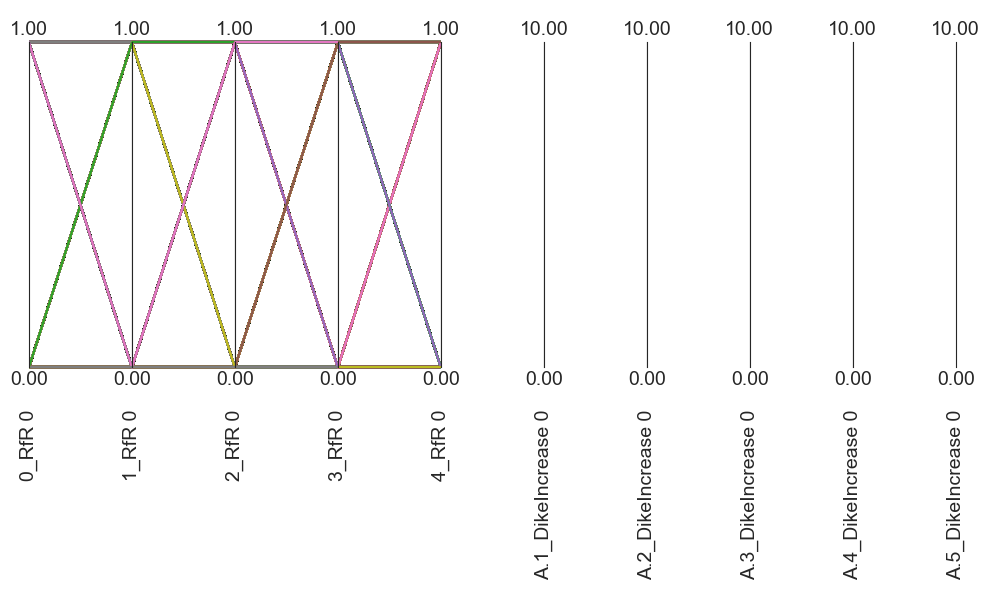

In [30]:
""" 
@Ryan
 """
#to_display = results.columns.tolist()
#excludeall EWS variables

to_display = ['0_RfR 0', '1_RfR 0', '2_RfR 0', '3_RfR 0', '4_RfR 0', 'A.1_DikeIncrease 0', 'A.2_DikeIncrease 0', 'A.3_DikeIncrease 0', 'A.4_DikeIncrease 0', 'A.5_DikeIncrease 0','Gelderland_Deaths', 'Gelderland_Damages', 'Gelderland_Investment', 'Overijssel_Deaths', 'Overijssel_Damages', 'Overijssel_Investment']
data = results.loc[:, to_display]
print(to_display)
limits = parcoords.get_limits(data)
limits.loc[0, to_display] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)


plt.show()


In [10]:
results.describe()

,Unnamed: 0,0_RfR 0,1_RfR 0,2_RfR 0,3_RfR 0,4_RfR 0,EWS_DaysToThreat,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,A.4_DikeIncrease 0,A.5_DikeIncrease 0,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Dike Investment Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Dike Investment Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Gelderland_Deaths,Gelderland_Damages,Gelderland_Investment,Overijssel_Deaths,Overijssel_Damages,Overijssel_Investment,Total_Deaths,Total_Damages,Total_Investment,Gelderland_RfR,Overijssel_RfR
count,8108.000000,8108.000000,8108.000000,8108.000000,8108.000000,8108.000000,8108.000000,8108.000000,8108.000000,8108.000000,8108.000000,8108.000000,8.108000e+03,8.108000e+03,8108.000000,8.108000e+03,8.108000e+03,8108.000000,8.108000e+03,8.108000e+03,8108.000000,8.108000e+03,8.108000e+03,8108.000000,8.108000e+03,8.108000e+03,8108.000000,8.108000e+03,8108.0,8108.000000,8.108000e+03,8.108000e+03,8108.000000,8.108000e+03,8.108000e+03,8108.000000,8.108000e+03,8.108000e+03,8108.000000,8108.000000
mean,4053.500000,0.393562,0.158855,0.527627,0.529600,0.240997,0.516897,2.208066,3.113098,2.665269,2.166502,2.345215,1.112457e+07,3.357120e+07,0.003080,8.302295e+06,4.745072e+07,0.003134,1.667073e+07,2.148427e+07,0.011785,3.209878e+06,6.738036e+06,0.000661,2.114984e+07,2.459851e+07,0.007577,2.099990e+08,0.0,0.017999,3.609760e+07,1.025062e+08,0.008237,2.435972e+07,3.133655e+07,0.026236,6.045732e+07,3.438417e+08,1.080044,0.770597
std,2340.722324,0.488570,0.365564,0.499267,0.499154,0.427715,0.499745,1.997655,1.799884,1.862802,1.810473,2.016912,3.963678e+07,1.944563e+07,0.010874,1.251789e+07,1.484956e+07,0.004655,2.589685e+07,8.896845e+06,0.018201,4.799255e+06,3.710479e+06,0.000968,3.622034e+07,1.320404e+07,0.012959,1.779099e+08,0.0,0.021009,4.726768e+07,2.661267e+07,0.012923,3.615001e+07,1.361925e+07,0.022824,5.457777e+07,1.764003e+08,0.806341,0.746300
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,3.035153e+07,0.000000,0.000000
25%,2026.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000e+00,3.269490e+07,0.000000,0.000000e+00,4.281842e+07,0.000000,0.000000e+00,2.029929e+07,0.000000,0.000000e+00,6.320800e+06,0.000000,0.000000e+00,2.503721e+07,0.000000,8.460000e+07,0.0,0.002115,4.900122e+06,8.581348e+07,0.000103,4.674104e+05,2.757823e+07,0.008932,2.294320e+07,2.015826e+08,1.000000,0.000000
50%,4053.500000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,2.000000,3.000000,3.000000,2.000000,2.000000,0.000000e+00,3.725520e+07,0.000000,1.595627e+06,4.784270e+07,0.000620,2.966101e+06,2.419803e+07,0.002115,4.779633e+05,7.332080e+06,0.000107,0.000000e+00,2.757823e+07,0.000000,1.519000e+08,0.0,0.009854,2.335823e+07,1.069410e+08,0.001947,7.430309e+06,3.473241e+07,0.020219,5.006739e+07,2.925354e+08,1.000000,1.000000
75%,6080.250000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,3.000000,4.000000,4.000000,3.000000,3.000000,0.000000e+00,4.229151e+07,0.000000,1.345806e+07,5.335857e+07,0.005156,2.552882e+07,2.640338e+07,0.018256,5.421202e+06,8.453408e+06,0.001132,3.669789e+07,3.035153e+07,0.013127,3.697000e+08,0.0,0.030867,4.560742e+07,1.194122e+08,0.013230,3.795754e+07,3.929887e+07,0.036231,7.514018e+07,4.797616e+08,2.000000,1.000000
max,8107.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,10.000000,10.000000,10.000000,1

In [37]:
#Political Filter
""" 
RFR on both provinces if any
Dike Increase > 5 on dike rin 3 and dike ring 5
Total Cost < 700 mio
 """
policies = results[(results["A.3_DikeIncrease 0"] > 5) & (results["A.5_DikeIncrease 0"] > 5)]
print(len(policies))
policies = policies[((policies["Gelderland_RfR"] > 0)&(policies["Overijssel_RfR"] > 0)) ]
print(len(policies))
#policies = policies[policies["Total_Investment"] < 900*10**6]
print(len(policies))
""" #Set threshiold for priority 1, 2 and 3: Deaths, Damages and Investment costs
distribution_threshold_deaths = 0.1
distribution_threshold_damages = 0.1
distribution_threshold_investment = 0.1
#Refine Policies-Dataframe to fit Priority 1 criterion
results2 = results.sort_values("Total_Deaths")
results2 = results.iloc[0:int(len(results2)*distribution_threshold_deaths),:]

#Refine Policies-Dataframe to fit Priority 2 criterion
results3 = results2.sort_values("Gelderland_Damages")
results3 = results3.iloc[0:int(len(results3)*distribution_threshold_damages),:]

#Refine Policies-Dataframe to fit Priority 3 criterion
results4 = results3.sort_values("Overijssel_Investment")
policies = results4.iloc[0:int(len(results4)*distribution_threshold_investment),:]
 """
pd.options.display.max_columns = None
display(policies)

49
9
9


,Unnamed: 0,0_RfR 0,1_RfR 0,2_RfR 0,3_RfR 0,4_RfR 0,EWS_DaysToThreat,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,A.4_DikeIncrease 0,A.5_DikeIncrease 0,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Dike Investment Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Dike Investment Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Gelderland_Deaths,Gelderland_Damages,Gelderland_Investment,Overijssel_Deaths,Overijssel_Damages,Overijssel_Investment,Total_Deaths,Total_Damages,Total_Investment,Gelderland_RfR,Overijssel_RfR
114,114,0,0,1,1,0,0,7,2,7,2,6,0.0,6.813900e+07,0.0,7.087017e+06,4.281842e+07,0.002708,0.0,3.422156e+07,0.0,4.674104e+05,7.332080e+06,0.000103,0.0,4.027367e+07,0.0,151900000.0,0.0,0.002708,7.087017e+06,1.451790e+08,0.000103,4.674104e+05,4.760575e+07,0.002811,7.554427e+06,3.446847e+08,1,1
1176,1176,1,0,1,1,1,0,4,4,7,1,7,0.0,4.784795e+07,0.0,0.000000e+00,5.335857e+07,0.000000,0.0,3.422156e+07,0.0,3.705277e+06,6.320800e+06,0.000780,0.0,4.419351e+07,0.0,492600000.0,0.0,0.000000,0.000000e+00,1.354281e+08,0.000780,3.705277e+06,5.051431e+07,0.000780,3.705277e+06,6.785424e+08,2,2
1609,1609,0,1,1,1,1,0,2,4,6,1,6,0.0,3.725520e+07,0.0,0.000000e+00,5.335857e+07,0.000000,0.0,3.139880e+07,0.0,3.705277e+06,6.320800e+06,0.000780,0.0,4.027367e+07,0.0,625800000.0,0.0,0.000000,0.000000e+00,1.220126e+08,0.000780,3.705277e+06,4.659447e+07,0.000780,3.705277e+06,7.944070e+08,2,2
3336,3336,0,0,1,1,0,0,2,3,6,2,7,0.0,3.725520e+07,0.0,1.587714e+06,4.784270e+07,0.000615,0.0,3.139880e+07,0.0,1.452903e+06,7.332080e+06,0.000323,0.0,4.419351e+07,0.0,151900000.0,0.0,0.000615,1.587714e+06,1.164967e+08,0.000323,1.452903e+06,5.152559e+07,0.000937,3.040617e+06,3.199223e+08,1,1
4079,4079,0,0,1,1,1,0,2,3,6,2,9,0.0,3.725520e+07,0.0,1.587714e+06,4.784270e+07,0.000615,0.0,3.139880e+07,0.0,0.000000e+00,7.332080e+06,0.000000,0.0,5.311400e+07,0.0,408000000.0,0.0,0.000615,1.587714e+06,1.164967e+08,0.000000,0.000000e+00,6.044608e+07,0.000615,1.587714e+06,5.849428e+08,1,2
4084,4084,0,1,1,1,0,1,2,3,7,2,7,0.0,3.725520e+07,0.0,1.587714e+06,4.784270e+07,0.000615,0.0,3.422156e+07,0.0,1.452903e+06,7.332080e+06,0.000323,0.0,4.419351e+07,0.0,369700000.0,0.0,0.000615,1.587714e+06,1.193195e+08,0.000323,1.452903e+06,5.152559e+07,0.000937,3.040617e+06,5.405451e+08,2,1
4431,4431,1,1,1,1,1,0,0,2,7,2,6,0.0,0.000000e+00,0.0,7.087017e+06,4.281842e+07,0.002708,0.0,3.422156e+07,0.0,0.000000e+00,7.332080e+06,0.000000,0.0,4.027367e+07,0.0,710400000.0,0.0,0.002708,7.087017e+06,7.703998e+07,0.000000,0.000000e+00,4.760575e+07,0.002708,7.087017e+06,8.350457e+08,3,2
4755,4755,0,0,1,1,0,1,4,3,6,2,6,0.0,4.784795e+07,0.0,1.587714e+06,4.784270e+07,0.000615,0.0,3.139880e+07,0.0,1.452903e+06,7.332080e+06,0.000323,0.0,4.027367e+07,0.0,151900000.0,0.0,0.000615,1.587714e+06,1.270894e+08,0.000323,1.452903e+06,4.760575e+07,0.000937,3.040617e+06,3.265952e+08,1,1
8077,8077,0,1,1,1,1,1,1,3,6,0,6,0.0,3.269490e+07,0.0,1.587714e+06,4.784270e+07,0.000615,0.0,3.139880e+07,0.0,6.245474e+06,0.000000e+00,0.001274,0.0,4.027367e+07,0.0,625800000.0,0.0,0.000615,1.587714e+06,1.119364e+08,0.001274,6.245474e+06,4.027367e+07,0.001889,7.833188e+06,7.780101e+08,2,2


In [10]:
#show 504
policies.iloc[2]

Unnamed: 0                       1.609000e+03
0_RfR 0                          0.000000e+00
1_RfR 0                          1.000000e+00
2_RfR 0                          1.000000e+00
3_RfR 0                          1.000000e+00
4_RfR 0                          1.000000e+00
EWS_DaysToThreat                 0.000000e+00
A.1_DikeIncrease 0               2.000000e+00
A.2_DikeIncrease 0               4.000000e+00
A.3_DikeIncrease 0               6.000000e+00
A.4_DikeIncrease 0               1.000000e+00
A.5_DikeIncrease 0               6.000000e+00
A.1_Expected Annual Damage       0.000000e+00
A.1_Dike Investment Costs        3.725520e+07
A.1_Expected Number of Deaths    0.000000e+00
A.2_Expected Annual Damage       0.000000e+00
A.2_Dike Investment Costs        5.335857e+07
A.2_Expected Number of Deaths    0.000000e+00
A.3_Expected Annual Damage       0.000000e+00
A.3_Dike Investment Costs        3.139880e+07
A.3_Expected Number of Deaths    0.000000e+00
A.4_Expected Annual Damage       3

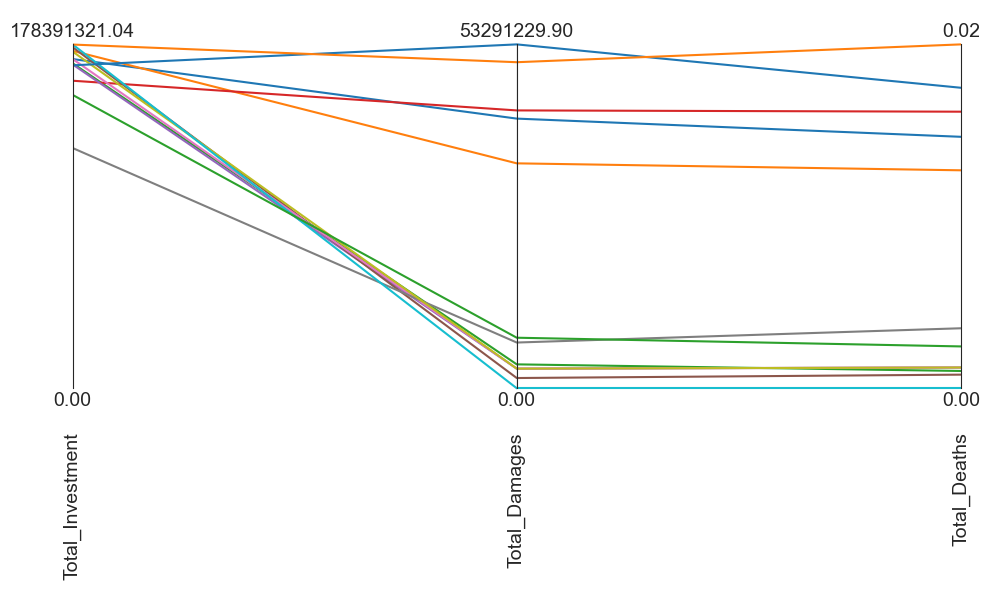

In [11]:



data = policies.loc[:, ["Total_Investment",
                        "Total_Damages",
                        "Total_Deaths",
                        ]]

limits = parcoords.get_limits(data)
limits.loc[0, [  "Total_Investment",
                        "Total_Damages",
                        "Total_Deaths",
                        ]] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)


plt.show()


#### 3b Robustness Analysis (Run Scenarios)

In [22]:

n_scenarios = 10000
# Policies are subsequently collected in a list as policy objects
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))


In [23]:

with MultiprocessingEvaluator(model) as evaluator:
    rob_results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)
    
save_results(rob_results, 'results/MORDM2_10k.tar.gz')



[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 10000 scenarios * 13 policies * 1 model(s) = 130000 experiments
  6%|█▉                                | 7325/130000 [06:04<1:49:09, 18.73it/s]

In [100]:
rob_results = load_results ('results/MORDM2_10k.tar.gz')

[MainProcess/INFO] results loaded successfully from /Users/alex/Documents/GitHub/model-based-decision-making/final_assignment/results/MORDM2_10k.tar.gz


#### 3c Visualize Results
1) Signal to Noise Ratio
2) Calculate Maximum regret
3) Scenario Dicovery to understand bad conditions

##### 3c1 Signal to Noise Ratio

In [88]:
#signal to noise - high value for maximizable outcomes is desirable
#outcome to have high average value and low standard deviation

def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [101]:
experiments, outcomes = rob_results

df = pd.DataFrame(outcomes)

In [102]:
df

,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Dike Investment Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Dike Investment Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,0.000000e+00,3.269490e+07,0.000000,0.000000e+00,5.335857e+07,0.000000,0.000000e+00,3.422156e+07,0.000000,0.000000e+00,6.320800e+06,0.000000,0.0,4.419351e+07,0.0,0.0,0.0
1,3.712387e+08,3.269490e+07,0.227871,0.000000e+00,5.335857e+07,0.000000,0.000000e+00,3.422156e+07,0.000000,3.471620e+06,6.320800e+06,0.001405,0.0,4.419351e+07,0.0,0.0,0.0
2,0.000000e+00,3.269490e+07,0.000000,1.153927e+07,5.335857e+07,0.010064,0.000000e+00,3.422156e+07,0.000000,0.000000e+00,6.320800e+06,0.000000,0.0,4.419351e+07,0.0,0.0,0.0
3,7.068919e+08,3.269490e+07,0.669879,0.000000e+00,5.335857e+07,0.000000,3.707255e+06,3.422156e+07,0.009607,0.000000e+00,6.320800e+06,0.000000,0.0,4.419351e+07,0.0,0.0,0.0
4,7.015064e+08,3.269490e+07,0.663456,3.277367e+07,5.335857e+07,0.040957,0.000000e+00,3.422156e+07,0.000000,0.000000e+00,6.320800e+06,0.000000,0.0,4.419351e+07,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129995,0.000000e+00,3.269490e+07,0.000000,8.962550e+06,4.784270e+07,0.012189,0.000000e+00,3.139880e+07,0.000000,2.178598e+07,0.000000e+00,0.013023,0.0,4.027367e+07,0.0,625800000.0,0.0
129996,0.000000e+00,3.269490e+07,0.000000,0.000000e+00,4.784270e+07,0.000000,0.000000e+00,3.139880e+07,0.000000,3.148769e+06,0.000000e+00,0.002195,0.0,4.027367e+07,0.0,625800000.0,0.0
129997,0.000000e+00,3.269490e+07,0.000000,0.000000e+00,4.784270e+07,0.000000,0.000000e+00,3.139880e+07,0.000000,4.974277e+06,0.000000e+00,0.002159,0.0,4.027367e+07,0.0,625800000.0,0.0
129998,0.000000e+00,3.269490e+07,0.000000,1.567250e+08,4.784270e+07,0.192654,0.000000e+00,3.139880e+07,0.000000,4.845673e+05,0.000000e+00,0.000309,0.0,4.027367e+07,0.0,625800000.0,0.0


In [103]:
df["Gelderland_Deaths"] = df[[f"A.{i+1}_Expected Number of Deaths" for i in range(3)]].sum(axis=1)
df["Gelderland_Damages"] = df[[f"A.{i+1}_Expected Annual Damage" for i in range(3)]].sum(axis=1)
df["Gelderland_Investment"] = df[[f"A.{i+1}_Dike Investment Costs" for i in range(3)]].sum(axis=1)
df["Overijssel_Deaths"] = df[[f"A.{i}_Expected Number of Deaths" for i in [4, 5]]].sum(axis=1)
df["Overijssel_Damages"] = df[[f"A.{i}_Expected Annual Damage" for i in [4, 5]]].sum(axis=1)
df["Overijssel_Investment"] = df[[f"A.{i}_Dike Investment Costs" for i in [4, 5]]].sum(axis=1)
df["Total_Deaths"] = df["Gelderland_Deaths"] + df["Overijssel_Deaths"]
df["Total_Damages"] = df["Gelderland_Damages"] + df["Overijssel_Damages"]
df["Total_Investment"] = df["Gelderland_Investment"] + df["Overijssel_Investment"]
outcomes = df.to_dict('list')



In [104]:
#For calculation of robustness, our outcomes dataframe is tranformed into a dictionary again
for k in outcomes.keys():
    outcomes[k] = np.array(outcomes[k])
outcome_names = [outcome.name for outcome in model.outcomes]
for name in ["Gelderland_Deaths", "Gelderland_Damages", "Gelderland_Investment","Overijssel_Deaths", "Overijssel_Damages", "Overijssel_Investment", "Total_Deaths", "Total_Damages", "Total_Investment"]:
    outcome_names.append(name)

    
# Calculation of signal-to-noise ratio per policy
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in outcome_names:
        value  = outcomes[outcome][logical]
        sn_ratio = s_to_n(value, -1)
        scores[outcome] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T

In [105]:
colors = sns.color_palette(n_colors=13)

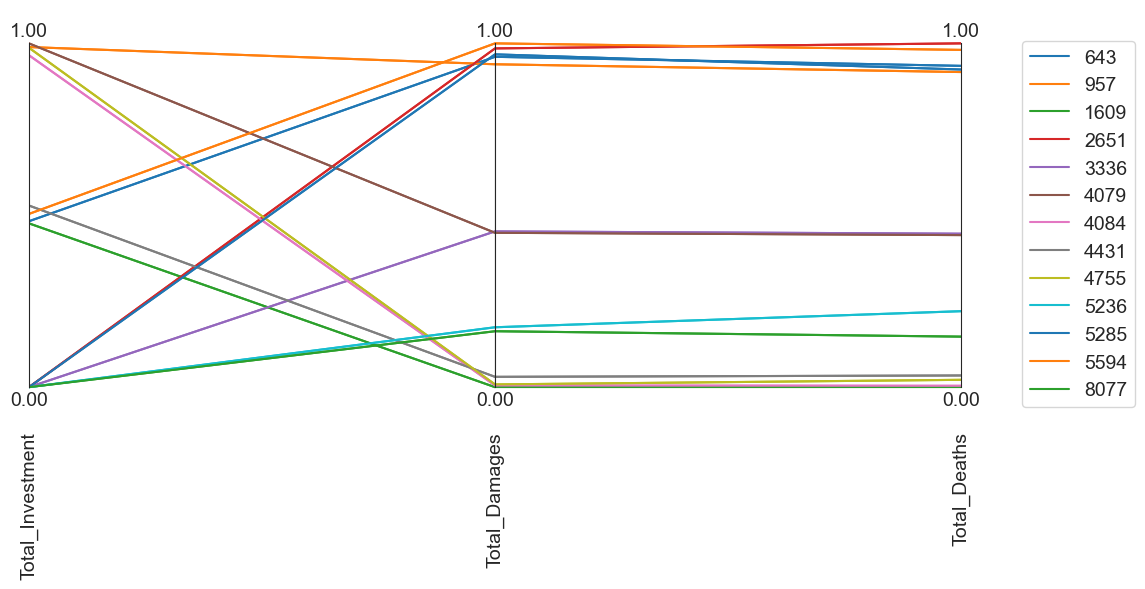

In [106]:

data = scores.loc[:, ["Total_Investment",
                        "Total_Damages",
                        "Total_Deaths",
                        ]]
data = ((data-data.min())/(data.max()-data.min()))
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
paraxes = parcoords.ParallelAxes(limits)
for j, (ind, row) in enumerate(data.reset_index().iterrows()):
            paraxes.plot(row.to_frame().T, label=int(row['index']),
                          color=colors[j])
paraxes.legend()
paraxes.plot(data)
plt.show()

        

##### 3c2 Calculate Regret

In [97]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [98]:
experiments, outcomes = rob_results
overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevant information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # Convert your DataFrame to a numpy array before multi-dimensional indexing
    data_array = data.to_numpy()

    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = np.abs(data_array.max(axis=1)[:, np.newaxis] - data_array)
    # Convert numpy array back to DataFrame
    outcome_regret_df = pd.DataFrame(outcome_regret, index=data.index, columns=data.columns)
    
    overall_regret[outcome.name] = outcome_regret_df
    max_regret[outcome.name] = outcome_regret_df.max()


visualize as heatmap

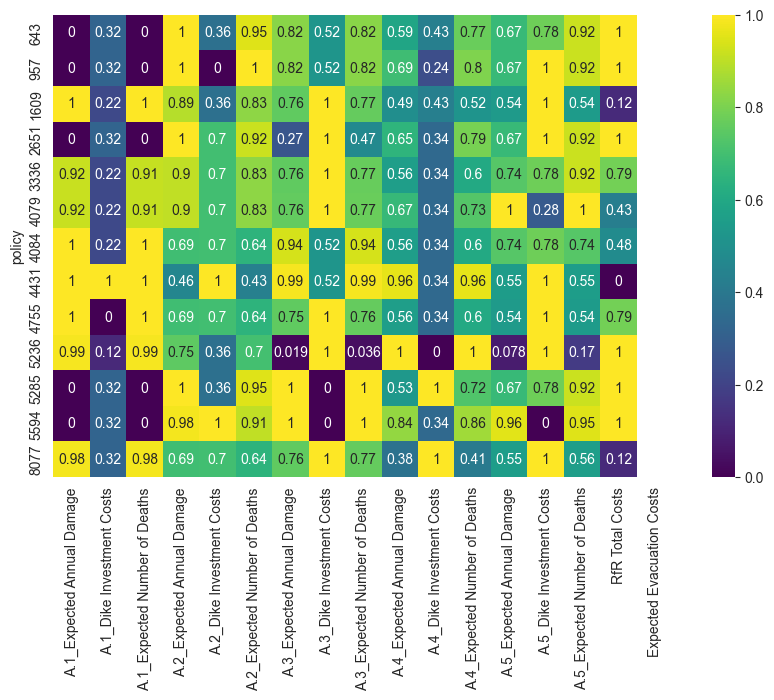

In [99]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

visualize as parallel axis

c:\Users\varun\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:219: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)
c:\Users\varun\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:280: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


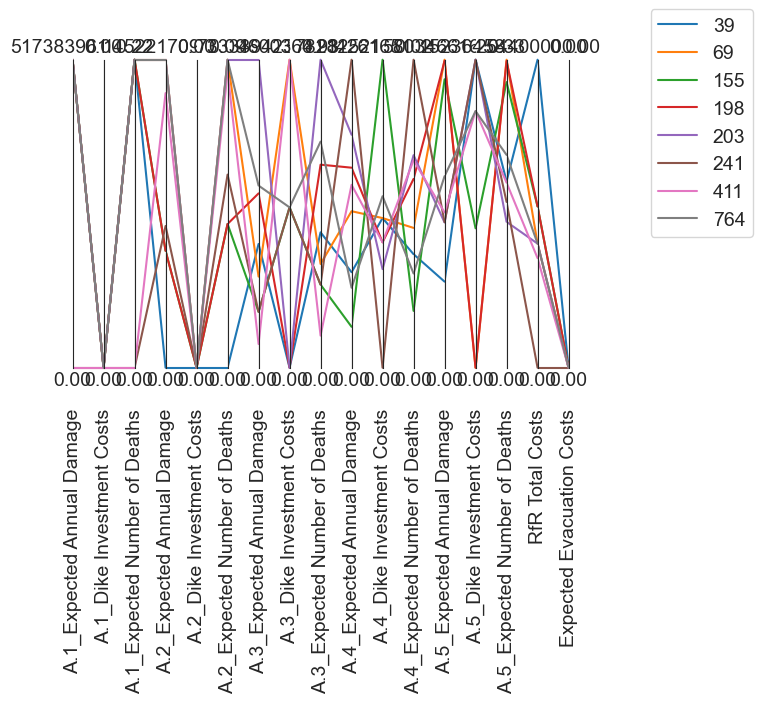

In [ ]:
colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, :] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()